# Water Pump Status

#### Flatiron Data Science Course - Project 3
#### Created by Nick Hall and Ahmad Samiee

## Project Overview
For this project we will solving a classification problem. We will use models appropriate for classification to make prediction for given unseen data.  The dateset is split into two, one for training the models and the other for testing/verifying the performance of our models. Also, we take the approach of trying a couple of different models starting out with simple model with low performance and working toward better models with better performance.

## Technical Summary
This project is a binary classification problem where prediction models are trained to predict the status of water pumps, especially those water pumps needing repair or operationally non-functional. Because of our business objective, we have decided to use recall for our model primary metric and accuracy for overall performance. Recall in this situation means what percentage of water pumps that are broken or need repair can our model predict correctly.  RandomForest is our best model with a recall of 0.77 and accuracy of 0.83.

## Business Problem
We have been tasked by our stakeholder, Tanzanian Ministry of Water, to setup a model that can predict water pumps needing repair or operationally non-functional. Because of our business objective, we have decided to use recall for our model metric. Recall in this situation means what percentage of water pumps that are broken or need repair can our model predict correctly.

## Master Dataset
The dataset was obtained from from [DrivenData](https://www.drivendata.org) and the records were collected by Taarifa and Tanzanian Ministry of Water.  After the data was read into pandas dataframe it was split into two where 70% of data (41,580 records) was used for training the models and 30% (17,820 records) was used to verify prediction performance of the various models.


## Data Cleaning,Feature Engineering and Processing
The original target consisted of three categories: 'functional', 'non-functional' and 'functional needs repair'. This was feature engineered into two categories by creating a new column. If the the pump was 'functional' a value of 0 was assigned to this new column and if the pump was 'non-fuctional' or 'functional needs repair' a value of 1 was assigned to this new column.<br>
Missing or NAN values for categorical features was filled with most frequent value and for numerical features the average for the column was used to fill in or replace. Most this was accomplished with sklearn Imputer. The the categorical features were then processed with sklearn's OneHotEncoder and the numerical features were processed with StandardScaler. The data was then split into train and test.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import recall_score,accuracy_score,plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay,confusion_matrix
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import time


%matplotlib inline

In [2]:
# Load data features

features = pd.read_csv('data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
features.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
# Load data target

target = pd.read_csv('data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
# Combine data features and target into single dataframe

combined_df = pd.concat([features,target['status_group']],axis=1)
combined_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
# check for NAN
combined_df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [7]:
# check for blank entries

combined_df[(combined_df == '') | (combined_df == ' ')].sum()

id                       0.0
amount_tsh               0.0
date_recorded            0.0
funder                   0.0
gps_height               0.0
installer                0.0
longitude                0.0
latitude                 0.0
wpt_name                 0.0
num_private              0.0
basin                    0.0
subvillage               0.0
region                   0.0
region_code              0.0
district_code            0.0
lga                      0.0
ward                     0.0
population               0.0
public_meeting           0.0
recorded_by              0.0
scheme_management        0.0
scheme_name              0.0
permit                   0.0
construction_year        0.0
extraction_type          0.0
extraction_type_group    0.0
extraction_type_class    0.0
management               0.0
management_group         0.0
payment                  0.0
payment_type             0.0
water_quality            0.0
quality_group            0.0
quantity                 0.0
quantity_group

In [8]:
# Check for duplicated records

combined_df[combined_df.duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [9]:
combined_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


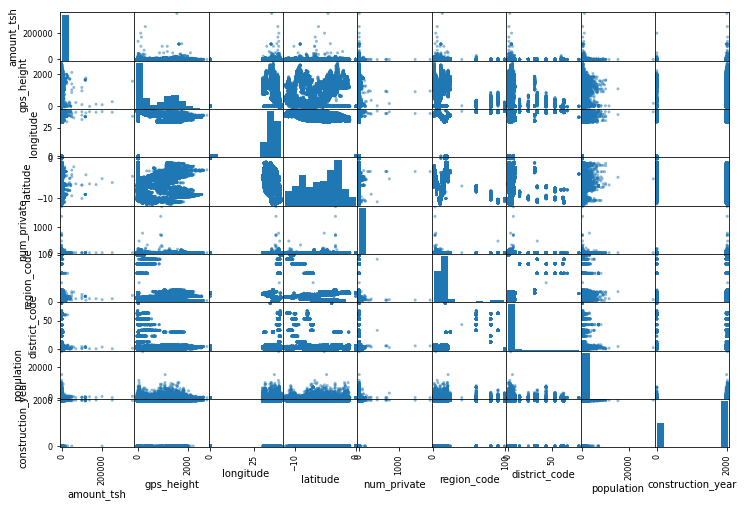

In [10]:
# Check plot matrix for numeric columns
numeric_features = combined_df.select_dtypes(include=['int64','float64'])                                            
numeric_cols_names = list(numeric_features.columns)
numeric_cols_names.pop(0)
pd.plotting.scatter_matrix(combined_df[numeric_cols_names],figsize=(12,8));

In [11]:
# split categorical features for from numerical
categorical_features = combined_df.select_dtypes(include=['object'])
numerical_features = combined_df.select_dtypes(include=['int64','float64'])

In [12]:
print('===== Categorical EDA ===='*3)

===== Categorical EDA ========= Categorical EDA ========= Categorical EDA ====


In [13]:
# Select which categorical features to include
categorical_columns = list(categorical_features.columns)
print(categorical_columns)
print(len(categorical_columns))

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']
31


In [14]:
# Go through each categorical column and decide which ones to include for
# analysis

num = 30
print(categorical_columns[num])
print(categorical_features[categorical_columns[num]].value_counts())

possible_cat_features_include = ['date_recorded','basin','region','public_meeting',
                          'scheme_management',
                   'permit','extraction_type','extraction_type_group',
                   'extraction_type_class','management','management_group',
                   'payment','payment_type','water_quality','quality_group',
                   'quantity','quantity_group','source','source_type','source_class',
                   'waterpoint_type','waterpoint_type_group','status_group']


cat_features_exclude = ['funder','installer','wpt_name','subvillage','lga','ward',
                   'recorded_by','scheme_name']


num_nans = categorical_features[categorical_columns[num]].isna().sum()
print('='*40)
print(f'Number of NaN for {categorical_columns[num]}: {num_nans}')

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
Number of NaN for status_group: 0


In [15]:
# compare the following categorical features to if they have the same information
# 'extraction_type','extraction_type_group','extraction_type_class'
# ==> use extraction_type and drop 'extraction_type_group'and 'extraction_type_class'

a = combined_df['extraction_type'].value_counts()
b = combined_df['extraction_type_group'].value_counts()
c = combined_df['extraction_type_class'].value_counts()
print(a,b,c)
print('='*80)

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64 gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: ext

In [16]:
# Compare 'management'and 'management_group' columns 

print(combined_df['management'].value_counts())
print(combined_df['management_group'].value_counts())
print('='*80)

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


In [17]:
# Compare 'payment' and 'payment_type' columns
# ==> use 'payment_type' and drop 'payment'

print(combined_df['payment'].value_counts())
print(combined_df['payment_type'].value_counts())
print('='*80)

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


In [18]:
# Compare 'water_quality' and 'quality_group'
# ==> use water quality and drop quality_group

print(combined_df['water_quality'].value_counts())
print(combined_df['quality_group'].value_counts())
print('='*80)

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


In [19]:
# Compare 'quantity' and 'quantity_group'
# ==> use quantity and drop quantity_group

print(combined_df['quantity'].value_counts())
print(combined_df['quantity_group'].value_counts())
print('='*80)

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


In [20]:
# Determined number of wells constructed before 2002

a = combined_df[combined_df['construction_year'] < 2002]
b = len(a)/len(combined_df)*100
b

69.93265993265993

In [21]:
# Compare 'waterpoint_type'and 'waterpoint_type_group'
# Keep water_type and drop the other

print(combined_df['waterpoint_type'].value_counts())
print(combined_df['waterpoint_type_group'].value_counts())
print('='*40)

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [22]:
print('=========== Numerical EDA ============' * 2)


=========== Numerical EDA ======================= Numerical EDA ============


In [23]:
# Check numerical colums
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 59400 non-null  int64  
 1   amount_tsh         59400 non-null  float64
 2   gps_height         59400 non-null  int64  
 3   longitude          59400 non-null  float64
 4   latitude           59400 non-null  float64
 5   num_private        59400 non-null  int64  
 6   region_code        59400 non-null  int64  
 7   district_code      59400 non-null  int64  
 8   population         59400 non-null  int64  
 9   construction_year  59400 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 4.5 MB


In [24]:
numerical_features.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


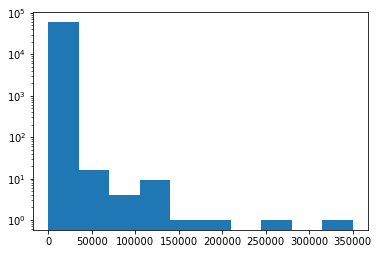

In [25]:
# amount_tsh
plt.hist(data=numerical_features, x='amount_tsh',bins=10,log=True);

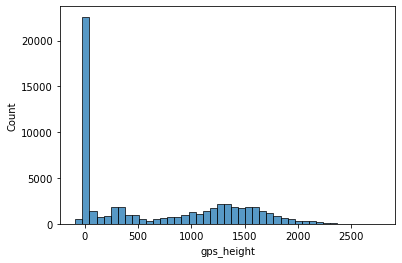

In [26]:
# gps_height
sns.histplot(data=numerical_features, x='gps_height');

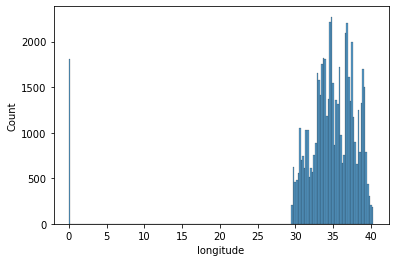

In [27]:
# longitude
sns.histplot(data=numerical_features, x='longitude');

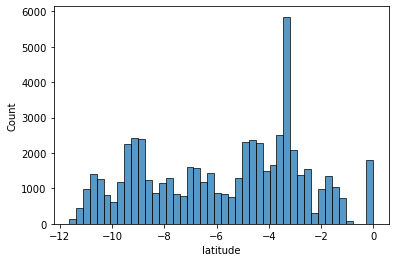

In [28]:
# latitude
sns.histplot(data=numerical_features, x='latitude');

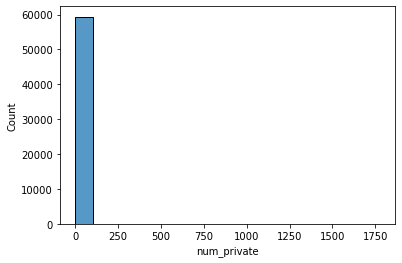

In [29]:
# 'num_private'
# ==> drop 'num_private'

sns.histplot(data=numerical_features, x='num_private');

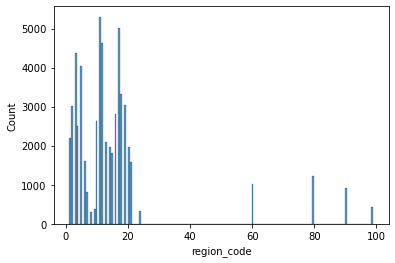

In [30]:
# region_code
sns.histplot(data=numerical_features, x='region_code');

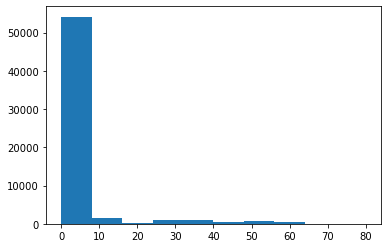

In [31]:
#district_code
#sns.histplot(data=numerical_features, x='district_code')
plt.hist(data=numerical_features, x='district_code');

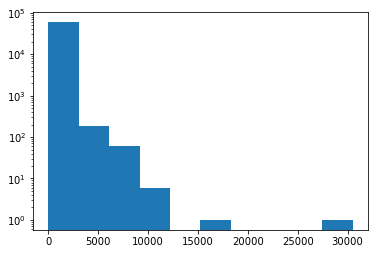

In [32]:
# population
#sns.histplot(data=numerical_features, x='population')
plt.hist(data=numerical_features, x='population',log=True);

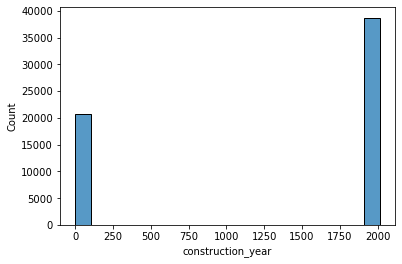

In [33]:
# construction_year
# ==> construction year has a lot of zeros, need to fix construction_year 

sns.histplot(data=numerical_features, x='construction_year',bins=20);

In [34]:
# Include the following categorical and numerical features based on EDA

cols_to_drop = ['extraction_type_group', 'extraction_type_class', 'payment', 
                'quality_group', 'quantity_group', 
                'waterpoint_type_group','funder','installer','wpt_name',
                'subvillage','lga','ward','recorded_by','scheme_name','id', 
                'num_private']

keep_columns = [col for col in combined_df.columns if(col not in cols_to_drop)]

combined_final_df = combined_df[keep_columns].copy()


combined_final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   date_recorded      59400 non-null  object 
 2   gps_height         59400 non-null  int64  
 3   longitude          59400 non-null  float64
 4   latitude           59400 non-null  float64
 5   basin              59400 non-null  object 
 6   region             59400 non-null  object 
 7   region_code        59400 non-null  int64  
 8   district_code      59400 non-null  int64  
 9   population         59400 non-null  int64  
 10  public_meeting     56066 non-null  object 
 11  scheme_management  55523 non-null  object 
 12  permit             56344 non-null  object 
 13  construction_year  59400 non-null  int64  
 14  extraction_type    59400 non-null  object 
 15  management         59400 non-null  object 
 16  management_group   594

In [35]:
# Create a 'rev_status' colum, assign 0 if 'status_group' equals functional
# and assign 1 if 'status_group' eqauls not functional or functional needs repair 

combined_final_df['rev_status'] = combined_final_df['status_group'].map(lambda x: 0 if(x == 'functional') else 1)
combined_final_df['rev_status'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: rev_status, dtype: float64

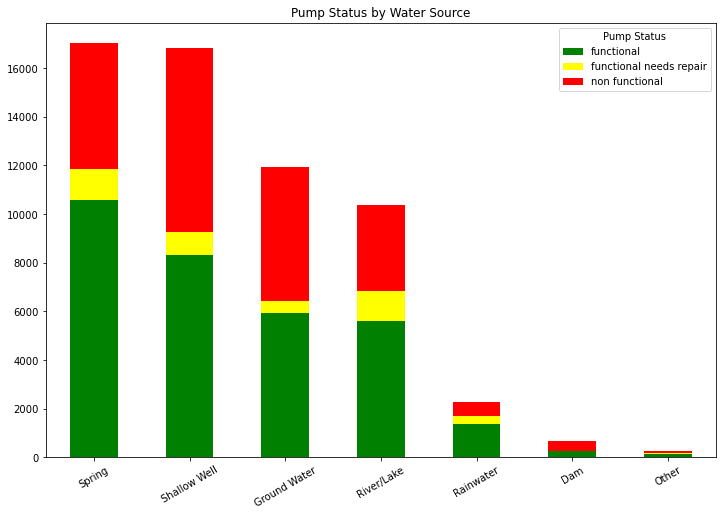

In [36]:
# Display pump status by water source

status_by_source = combined_final_df.groupby(['source_type','status_group'])['status_group'].agg('count')



table = pd.pivot_table(combined_final_df,values='gps_height',
                       index='source_type',columns='status_group',
                       aggfunc='count')
#print(table)
#print('='*80)


table = table.reindex(table['functional'].sort_values(ascending=False).index)
table_plot = table.plot.bar(figsize=(12,8),stacked=True,
              title='Pump Status by Water Source',
              color=['green','yellow','red'])

#table_plot.set_yscale('log')
table_plot.set_xticklabels(rotation=30,labels=['Spring','Shallow Well','Ground Water',
                                              'River/Lake', 'Rainwater', 'Dam', 'Other'])
table_plot.set_xlabel('')
table_plot.legend(title='Pump Status');

#plt.savefig('pump_status2.jpeg')



In [37]:
# Split dataframe into features and target copies

final_features = combined_final_df.drop(['status_group','rev_status'],axis=1).copy()
final_target = combined_final_df['rev_status'].copy()
final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   date_recorded      59400 non-null  object 
 2   gps_height         59400 non-null  int64  
 3   longitude          59400 non-null  float64
 4   latitude           59400 non-null  float64
 5   basin              59400 non-null  object 
 6   region             59400 non-null  object 
 7   region_code        59400 non-null  int64  
 8   district_code      59400 non-null  int64  
 9   population         59400 non-null  int64  
 10  public_meeting     56066 non-null  object 
 11  scheme_management  55523 non-null  object 
 12  permit             56344 non-null  object 
 13  construction_year  59400 non-null  int64  
 14  extraction_type    59400 non-null  object 
 15  management         59400 non-null  object 
 16  management_group   594

In [38]:
# Split final_features and final_target for train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_features,
                                                   final_target,
                                                    test_size = 0.3,
                                                   random_state=1234,
                                                   stratify=final_target)

In [39]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.543074
1    0.456926
Name: rev_status, dtype: float64
0    0.543098
1    0.456902
Name: rev_status, dtype: float64


In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 42910 to 11242
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         41580 non-null  float64
 1   date_recorded      41580 non-null  object 
 2   gps_height         41580 non-null  int64  
 3   longitude          41580 non-null  float64
 4   latitude           41580 non-null  float64
 5   basin              41580 non-null  object 
 6   region             41580 non-null  object 
 7   region_code        41580 non-null  int64  
 8   district_code      41580 non-null  int64  
 9   population         41580 non-null  int64  
 10  public_meeting     39283 non-null  object 
 11  scheme_management  38872 non-null  object 
 12  permit             39445 non-null  object 
 13  construction_year  41580 non-null  int64  
 14  extraction_type    41580 non-null  object 
 15  management         41580 non-null  object 
 16  management_group  

In [41]:
# Create X_trian for numerical features

X_train_nums = X_train.select_dtypes(['float64','int64'])
X_train_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 42910 to 11242
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         41580 non-null  float64
 1   gps_height         41580 non-null  int64  
 2   longitude          41580 non-null  float64
 3   latitude           41580 non-null  float64
 4   region_code        41580 non-null  int64  
 5   district_code      41580 non-null  int64  
 6   population         41580 non-null  int64  
 7   construction_year  41580 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 2.9 MB


In [42]:
# Create X_train for categorical features

X_train_cats = X_train.select_dtypes('object')
X_train_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 42910 to 11242
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date_recorded      41580 non-null  object
 1   basin              41580 non-null  object
 2   region             41580 non-null  object
 3   public_meeting     39283 non-null  object
 4   scheme_management  38872 non-null  object
 5   permit             39445 non-null  object
 6   extraction_type    41580 non-null  object
 7   management         41580 non-null  object
 8   management_group   41580 non-null  object
 9   payment_type       41580 non-null  object
 10  water_quality      41580 non-null  object
 11  quantity           41580 non-null  object
 12  source             41580 non-null  object
 13  source_type        41580 non-null  object
 14  source_class       41580 non-null  object
 15  waterpoint_type    41580 non-null  object
dtypes: object(16)
memory usage: 5.4+ MB


In [43]:
# Setup numerical and categorical pipeline and incorporate both into
# ColumnTransformer

num_pipeline = Pipeline(steps=[
    ('num_impute',SimpleImputer(strategy='mean')),
    ('num_ss',StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('cat_ohe', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

cat_pipeline2 = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('cat_ord',OrdinalEncoder())])

trans = ColumnTransformer(transformers=[
    ('numerical',num_pipeline,X_train_nums.columns),
    ('categorical',cat_pipeline,X_train_cats.columns)])

trans2 = ColumnTransformer(transformers=[
    ('numerical',num_pipeline,X_train_nums.columns),
    ('categorical',cat_pipeline,X_train_cats.columns)])


# Model Development
For model development we ultilized sklearn Pipeline and GridSearchCV to efficiently test out our models. We evaluated the data with the following models: 
* DummyClassifier as base model
* Logistic Regression
* DecisionTreeClassifier 
* KNeighborsClassifier
* VotingClassifier with DecisionTreeClassifier and KNeighborsClassifier
* RandomForestClassifier

In [44]:
# Use this function to plot ROC curve 

def plot_roc_curve(y_actuals,y_predict,model_name):
    '''
    Compute false positive rates(fpr) and true positive rates(tpr) and display ROC curve.
    '''
    
    #fig,ax = plt.subplots(figsize=(10,10))
    fpr, tpr, thresholds = metrics.roc_curve(y_actuals, y_predict)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name=model_name)
    display.plot();     

In [45]:
def show_results(model,actuals,predictions,model_name):
    '''
    Print out metrics for validation and test samples. 
    '''
    
    # Incorporate cv_results into pandas dataframe
    base_cv_results = pd.DataFrame([model.cv_results_])
    accuracy = base_cv_results['mean_test_accuracy'].mean()[0]
    
    print('='*40)
    print(f'Validation recall score: {model.best_score_}')
    print(f'Validation accuracy score: {accuracy}')
    print(f'Best paramets: {model.best_params_}')
    print('='*40)
    
    # Predict for X_test samples
    print(f'Test sample prediction result for: {model_name}.')

    recall = recall_score(actuals,predictions)
    accuracy = accuracy_score(actuals,predictions)
    print(f'Test recall score: {recall}\nTest accuracy score: {accuracy}')
    print('='*40)
    

In [46]:
# Create base model Pipe for DummyClassifier

start = time.time()
base_model_pipe = Pipeline(steps=[
    ('trans',trans),
    ('dummy_model',DummyClassifier(strategy='prior'))])

# Specify parameters for DummyClassifier GridSearch and incorpoare base model
# Pipe into GridSearchCV
base_parameters = {
    'dummy_model__random_state': [1234],
    'dummy_model__strategy' : ['prior']
}

base_grid_model = GridSearchCV(estimator = base_model_pipe,
                          param_grid=base_parameters,refit='recall',
                         scoring=['recall','accuracy'])

# Fit train data for base model
base_grid_model.fit(X_train,y_train)

stop = time.time()
print(f'Time run this DummyClassifier: {stop-start}')


Time run this DummyClassifier: 32.915385007858276


Validation recall score: 0.0
Validation accuracy score: 0.543073593073593
Best paramets: {'dummy_model__random_state': 1234, 'dummy_model__strategy': 'prior'}
Test sample prediction result for: DummyClassifier.
Test recall score: 0.0
Test accuracy score: 0.5430976430976431


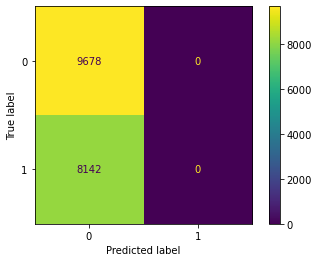

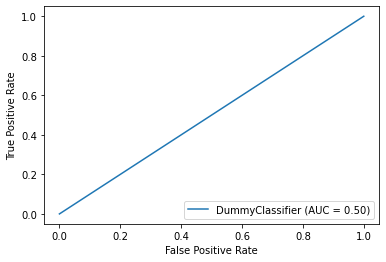

In [47]:
# Predict for test samples

base_y_test_pred = base_grid_model.predict(X_test)

show_results(base_grid_model,y_test,base_y_test_pred,'DummyClassifier')

      
# Plot confusion and ROC curve
#print(confusion_matrix(y_test,base_y_test_pred))
plot_confusion_matrix(base_grid_model,X_test,y_test);
plot_roc_curve(y_test,base_y_test_pred,'DummyClassifier')

In [48]:
# Create model Pipe for Logistic Regression
start = time.time()
lr_model_pipe = Pipeline(steps=[
    ('trans',trans),
    ('lr_model',LogisticRegression())])

# Specify grid parameters for lr_model and incorporate into GridSearch
lr_parameters = {
    'trans__numerical__num_ss__with_mean' : [True],  #tried False
    #'lr_model__penalty' : ['l2','l1','elasticnet'], #too many warnings gets generated
    'lr_model__random_state' : [1234],
    'lr_model__C' : [1e3],  #tried 1e-3,1,10e3 and 10e9
    'lr_model__max_iter' : [5e3],  #tried 1e4
    'lr_model__solver' : ['lbfgs'] #tried also 'liblinear' 
}

lr_grid_model = GridSearchCV(estimator = lr_model_pipe,
                          param_grid=lr_parameters,refit='recall',
                          scoring=['recall','accuracy'])

# Train model with train sample
lr_grid_model.fit(X_train,y_train)
stop = time.time()
print(f'Time to run this Logistic Classifier grid: {stop-start}')


Time to run this Logistic Classifier grid: 230.6871440410614


Validation recall score: 0.6378758537565288
Validation accuracy score: 0.751948051948052
Best paramets: {'lr_model__C': 1000.0, 'lr_model__max_iter': 5000.0, 'lr_model__random_state': 1234, 'lr_model__solver': 'lbfgs', 'trans__numerical__num_ss__with_mean': True}
Test sample prediction result for: Logistic Regression.
Test recall score: 0.6478752149349054
Test accuracy score: 0.7602693602693603


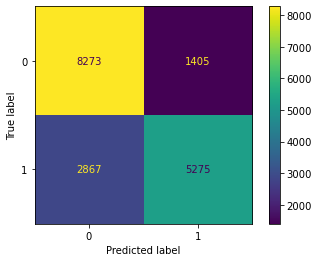

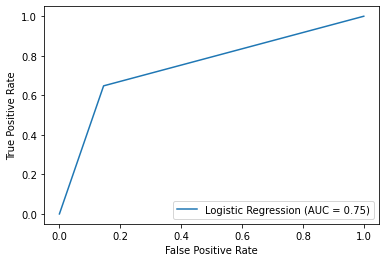

In [49]:
# Predict for test samples

lr_y_test_pred = lr_grid_model.predict(X_test)

show_results(lr_grid_model,y_test,lr_y_test_pred,'Logistic Regression')

      
# Plot confusion and ROC curve
#print(confusion_matrix(y_test,base_y_test_pred))
plot_confusion_matrix(lr_grid_model,X_test,y_test);
plot_roc_curve(y_test,lr_y_test_pred,'Logistic Regression')


In [50]:
# Create base model Pipe for DecisionTreeClassifier 
start = time.time()
dt_model_pipe = Pipeline(steps=[
    ('trans',trans),
    ('dtree_model',DecisionTreeClassifier())])

# Specify parameters for DecisionTreeClassifier GridSearch and incorpoare 
# dtree_model Pipe into GridSearchCV
dt_parameters = {
    'dtree_model__random_state' : [1234],
    'dtree_model__max_depth': [45],   #tried 3,5,10,30,60(best),90
    'dtree_model__min_impurity_decrease' : [0], # tried 0,0.3
    'dtree_model__max_features' : ['auto'] #tried 'sqrt'
}

dtree_grid_model = GridSearchCV(estimator = dt_model_pipe,
                          param_grid=dt_parameters,refit='recall',
                         scoring=['recall','accuracy'])

# Fit train data into dtree_grid_model
dtree_grid_model.fit(X_train,y_train)


stop = time.time()
print(f'Time to run this Decision Tree Classifier grid: {stop-start}.')

Time to run this Decision Tree Classifier grid: 32.69727897644043.


Validation recall score: 0.745354982613153
Validation accuracy score: 0.770947570947571
Best paramets: {'dtree_model__max_depth': 45, 'dtree_model__max_features': 'auto', 'dtree_model__min_impurity_decrease': 0, 'dtree_model__random_state': 1234}
Test sample prediction result for: DecisionTreeClassifier.
Test recall score: 0.7557111274871039
Test accuracy score: 0.7783389450056116


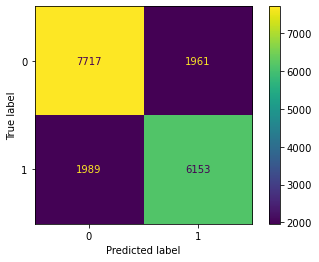

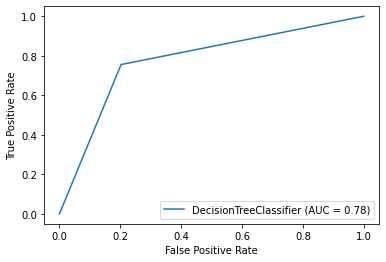

In [51]:
# Predict for test samples

dtree_y_test_pred = dtree_grid_model.predict(X_test)

show_results(dtree_grid_model,y_test,dtree_y_test_pred,'DecisionTreeClassifier')

      
# Plot confusion and ROC curve
#print(confusion_matrix(y_test,base_y_test_pred))
plot_confusion_matrix(dtree_grid_model,X_test,y_test);
plot_roc_curve(y_test,dtree_y_test_pred,'DecisionTreeClassifier')


In [52]:
# Create model Pipe for KNeighborsClassifier
start = time.time()
knn_model_pipe = Pipeline(steps=[
    ('trans',trans),
    ('knn_model',KNeighborsClassifier())])

# Specify parameters for KNeighborsClassifier GridSearch and incorpoare 
# knn_model Pipe into GridSearchCV
knn_parameters = {
    'knn_model__n_neighbors' : [3], #tried 3(best),5,10 and 1 may take too long
    'knn_model__weights' : ['uniform'],   #tried ['uniform','distance'] distance(best)
    'knn_model__leaf_size' : [5] # 5,15
}

knn_grid_model = GridSearchCV(estimator = knn_model_pipe,
                          param_grid=knn_parameters,refit='recall',
                          scoring=['recall','accuracy'])

# Fit train data into knn_grid_model
knn_grid_model.fit(X_train,y_train)


stop = time.time()
print(f'Time to run KNeighbor Classifier grid: {stop-start}.')

Time to run KNeighbor Classifier grid: 169.7671082019806.


Validation recall score: 0.7341959934054669
Validation accuracy score: 0.782058682058682
Best paramets: {'knn_model__leaf_size': 5, 'knn_model__n_neighbors': 3, 'knn_model__weights': 'uniform'}
Test sample prediction result for: KNeighborsClassifier.
Test recall score: 0.7557111274871039
Test accuracy score: 0.7783389450056116


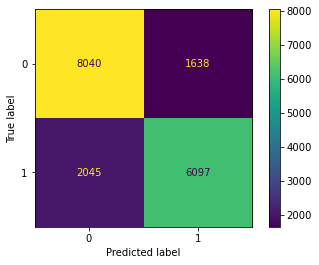

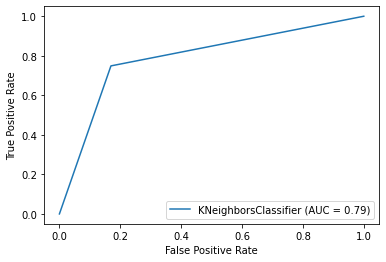

In [53]:
# Predict for test samples

knn_y_test_pred = knn_grid_model.predict(X_test)

show_results(knn_grid_model,y_test,dtree_y_test_pred,'KNeighborsClassifier')

      
# Plot confusion and ROC curve
#print(confusion_matrix(y_test,base_y_test_pred))
plot_confusion_matrix(knn_grid_model,X_test,y_test);
plot_roc_curve(y_test,knn_y_test_pred,'KNeighborsClassifier')


In [54]:
# Instantiate DecisionTreeClassifier and KNeighbors estimater with specified 
# parameters and then instantiate VotingClassifier and incoporate decision tree
# knn estimators into it
start = time.time()
dctree = DecisionTreeClassifier(random_state=1234,max_depth=60,
                                max_features='auto')

knneighbor = KNeighborsClassifier(n_neighbors=3, leaf_size=15,weights='distance')

vc_model_pipe = Pipeline(steps=[
    ('trans',trans),
    ('vc_model',VotingClassifier(estimators=[
        ('dctree',dctree),('knneighbor',knneighbor)]))])

# Specify parameters for vc_model and incorporate into GridSearch
vc_parameters = {
    'vc_model__voting' : ['soft'],
    'vc_model__weights': [[0.4,0.6]] #tried [0.4,0.6],[0.2,0.8]
}


vc_grid_model = GridSearchCV(estimator = vc_model_pipe,
                          param_grid=vc_parameters,refit='recall',
                          scoring=['recall','accuracy'])

# Fit train data into vc_grid_model
vc_grid_model.fit(X_train,y_train)


stop = time.time()
print(f'Time to run this vc_model grid: {stop-start}')

Time to run this vc_model grid: 159.66827702522278


Validation recall score: 0.7531447195245287
Validation accuracy score: 0.785954785954786
Best paramets: {'vc_model__voting': 'soft', 'vc_model__weights': [0.4, 0.6]}
Test sample prediction result for: VotingClassifier with DecisionTreeClassifier and KNeighbors.
Test recall score: 0.7618521247850651
Test accuracy score: 0.7924242424242425


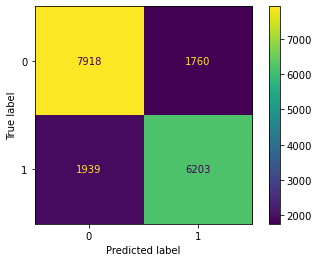

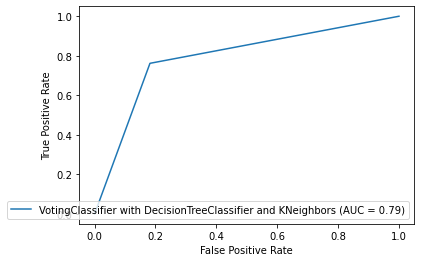

In [55]:
# Predict for test samples

vc_y_test_pred = vc_grid_model.predict(X_test)

show_results(vc_grid_model,y_test,vc_y_test_pred,
             'VotingClassifier with DecisionTreeClassifier and KNeighbors')

      
# Plot confusion and ROC curve
#print(confusion_matrix(y_test,base_y_test_pred))
plot_confusion_matrix(vc_grid_model,X_test,y_test);
plot_roc_curve(y_test,vc_y_test_pred,
               'VotingClassifier with DecisionTreeClassifier and KNeighbors')


In [56]:
# Create model Pipe for RandomForestClassifier
start = time.time()
rfc_model_pipe = Pipeline(steps=[
    ('trans',trans),
    ('rfc_model',RandomForestClassifier())])

# Specify parameters rfc_model_pipe GridSearch and incorpoare 
# rfc_model pipe into GridSearchCV
rfc_parameters = {
    'rfc_model__n_estimators': [100], #tried 100,200
    'rfc_model__criterion' : ['gini', 'entropy'],  #log_loss gives warnings
    'rfc_model__max_samples' : [0.5],  # tried 0.3,0.5
    'rfc_model__max_features' : ['sqrt'], # tried 'sqrt','log2'
    'rfc_model__random_state' : [123],
    'rfc_model__max_depth' : [60] # tried 30,60,75
}

rfc_grid_model = GridSearchCV(estimator = rfc_model_pipe,
                          param_grid=rfc_parameters,refit='recall',
                          scoring=['recall','accuracy'])

# Fit train data into rfc_grid_model
rfc_grid_model.fit(X_train,y_train)
stop = time.time()
print(f'Time to run this rfc_grid_model and grid: {stop-start}.')

Time to run this rfc_grid_model and grid: 142.37469696998596.


Validation recall score: 0.7571974480819053
Validation accuracy score: 0.8162097162097162
Best paramets: {'rfc_model__criterion': 'entropy', 'rfc_model__max_depth': 60, 'rfc_model__max_features': 'sqrt', 'rfc_model__max_samples': 0.5, 'rfc_model__n_estimators': 100, 'rfc_model__random_state': 123}
Test sample prediction result for: RandomForestClassifier.
Test recall score: 0.7704495210022108
Test accuracy score: 0.8282828282828283


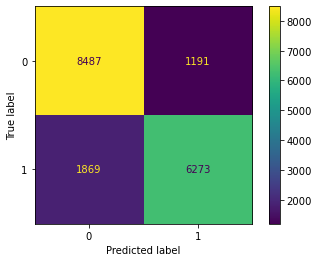

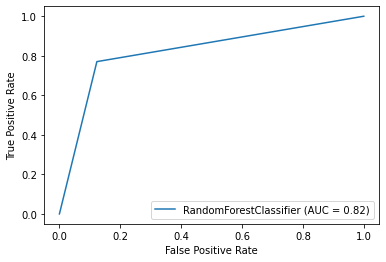

In [57]:
# Predict for test samples

rfc_y_test_pred = rfc_grid_model.predict(X_test)

show_results(rfc_grid_model,y_test,rfc_y_test_pred,'RandomForestClassifier')

      
# Plot confusion and ROC curve
#print(confusion_matrix(y_test,base_y_test_pred))
plot_confusion_matrix(rfc_grid_model,X_test,y_test);
plot_roc_curve(y_test,rfc_y_test_pred,'RandomForestClassifier')


# Conclusion

This project is a binary classification problem where prediction models are trained to predict the status of water pumps, especially those water pumps needing repair or operationally non-functional. Because of our business objective, we have decided to use recall for our model primary metric and accuracy for overall performance. Recall in this situation means what percentage of water pumps that are broken or need repair can our model predict correctly. Our base model is DummyClassifier which gave a recall 0 and accuracy of 0.54.  Logistic Regression provides better predictions with a recall of 0.65 and accuracy of 0.76.  The next four models which are DecisionTree, KNeighbors, VotingClassifier (with DecisonTree and KNeighbors and Random Forest give similar result with a recall between 0.76 - 0.77 and accuracy between 0.78 - 0.83. RandomForest gives a slightly better performance with a recall of 0.77 and accuracy of 0.83 and therefore it is our best model.  